In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

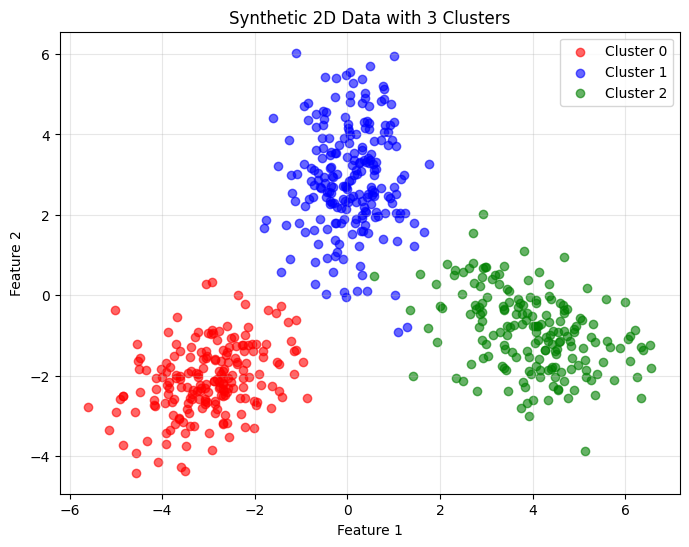

In [2]:
# Generate synthetic 2D data with 3 clusters
k = 3  # number of clusters
n_features = 2  # 2D data (x, y)
ndata = 600

# True cluster parameters
true_centers = np.array([[-3, -2], [0, 3], [4, -1]])
true_covs = [
    [[1.0, 0.3], [0.3, 0.8]],  # cluster 0: correlated
    [[0.5, 0.0], [0.0, 2.0]],  # cluster 1: uncorrelated, different scales
    [[1.2, -0.4], [-0.4, 1.0]],  # cluster 2: negative correlation
]

# Generate data
cluster_ids = rng.integers(0, k, ndata)
X = np.zeros((ndata, n_features))

for i in range(ndata):
    cluster = cluster_ids[i]
    X[i] = rng.multivariate_normal(true_centers[cluster], true_covs[cluster])

# Plot synthetic data
plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green"]
for i in range(k):
    mask = cluster_ids == i
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.6, label=f"Cluster {i}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic 2D Data with 3 Clusters")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


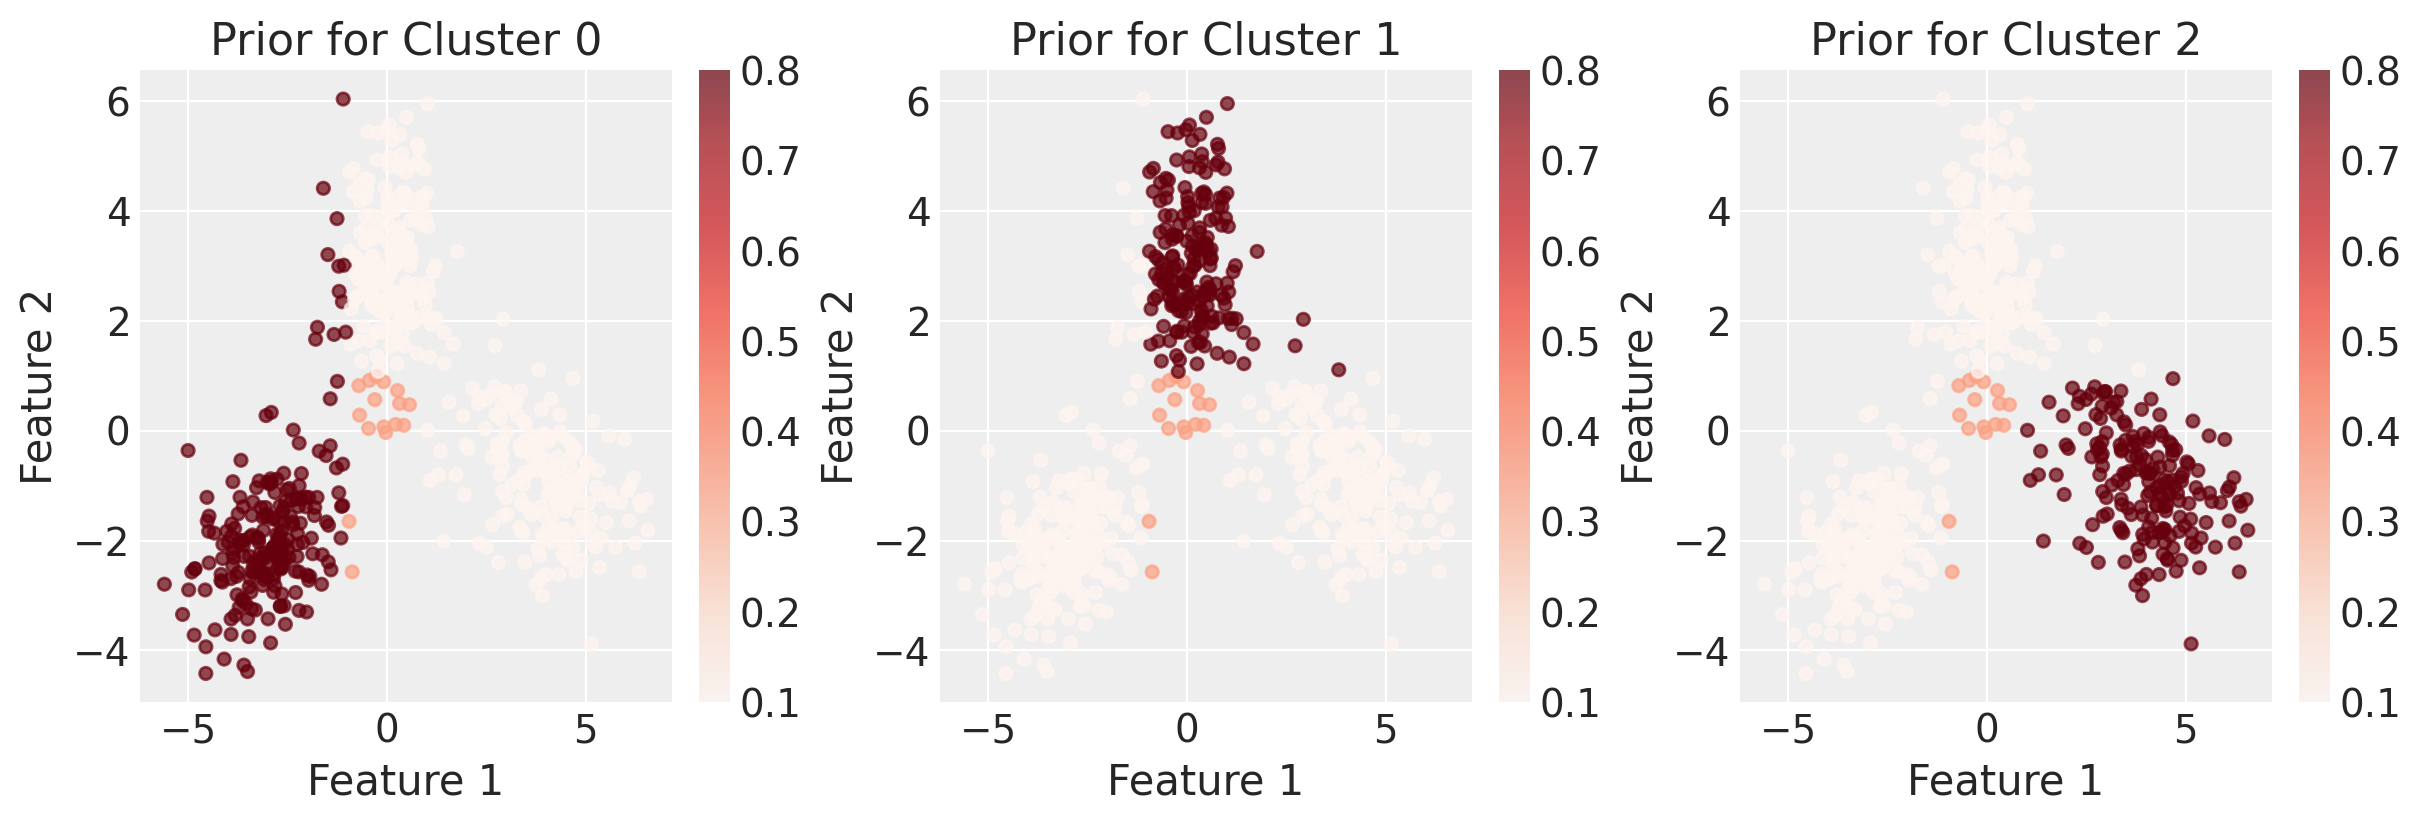

In [ ]:
# Create spatial regions (rectangles) to define priors
# Region 0: left side (x < -1)
# Region 1: top (y > 1)
# Region 2: bottom-right (x > 1 and y < 1)


def assign_spatial_priors(X, k):
    """Assign prior probabilities based on spatial regions."""
    ndata = X.shape[0]
    prior_probs = np.ones((ndata, k)) / k  # default uniform

    for i in range(ndata):
        x, y = X[i]

        if x < -1:  # Region 0: left side -> prefer cluster 0
            prior_probs[i] = [0.8, 0.1, 0.1]
        elif y > 1:  # Region 1: top -> prefer cluster 1
            prior_probs[i] = [0.1, 0.8, 0.1]
        elif x > 1 and y < 1:  # Region 2: bottom-right -> prefer cluster 2
            prior_probs[i] = [0.1, 0.1, 0.8]
        # else: keep uniform [1/3, 1/3, 1/3]

    return prior_probs


prior_probs = assign_spatial_priors(X, k)

# Visualize priors
plt.figure(figsize=(12, 4))
for cluster in range(k):
    plt.subplot(1, 3, cluster + 1)
    scatter = plt.scatter(
        X[:, 0], X[:, 1], c=prior_probs[:, cluster], cmap="Reds", s=20, alpha=0.7
    )
    plt.colorbar(scatter)
    plt.title(f"Prior for Cluster {cluster}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
plt.show()


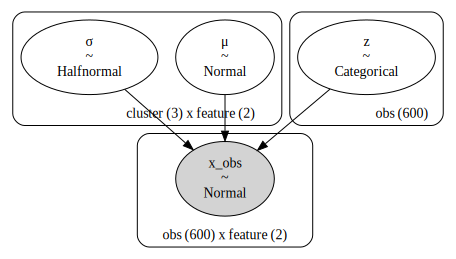

In [24]:
# PyMC model with multivariate Gaussian mixture and spatial priors
with pm.Model(
    coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
) as model:
    # Cluster means (multivariate)
    μ = pm.Normal("μ", mu=0, sigma=5, dims=("cluster", "feature"))

    # Cluster standard deviations (diagonal covariance for simplicity)
    σ = pm.HalfNormal("σ", sigma=3, dims=("cluster", "feature"))

    # Cluster assignments with spatial priors (key difference!)
    z = pm.Categorical("z", p=prior_probs, dims="obs")

    # Likelihood: each point comes from its assigned cluster
    pm.Normal("x_obs", mu=μ[z], sigma=σ[z], observed=X, dims=("obs", "feature"))

pm.model_to_graphviz(model)


In [25]:
# Sample from the model
with model:
    idata = pm.sample(1000, tune=1000, target_accept=0.9)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [μ, σ]
>CategoricalGibbsMetropolis: [z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.
/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [ ]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

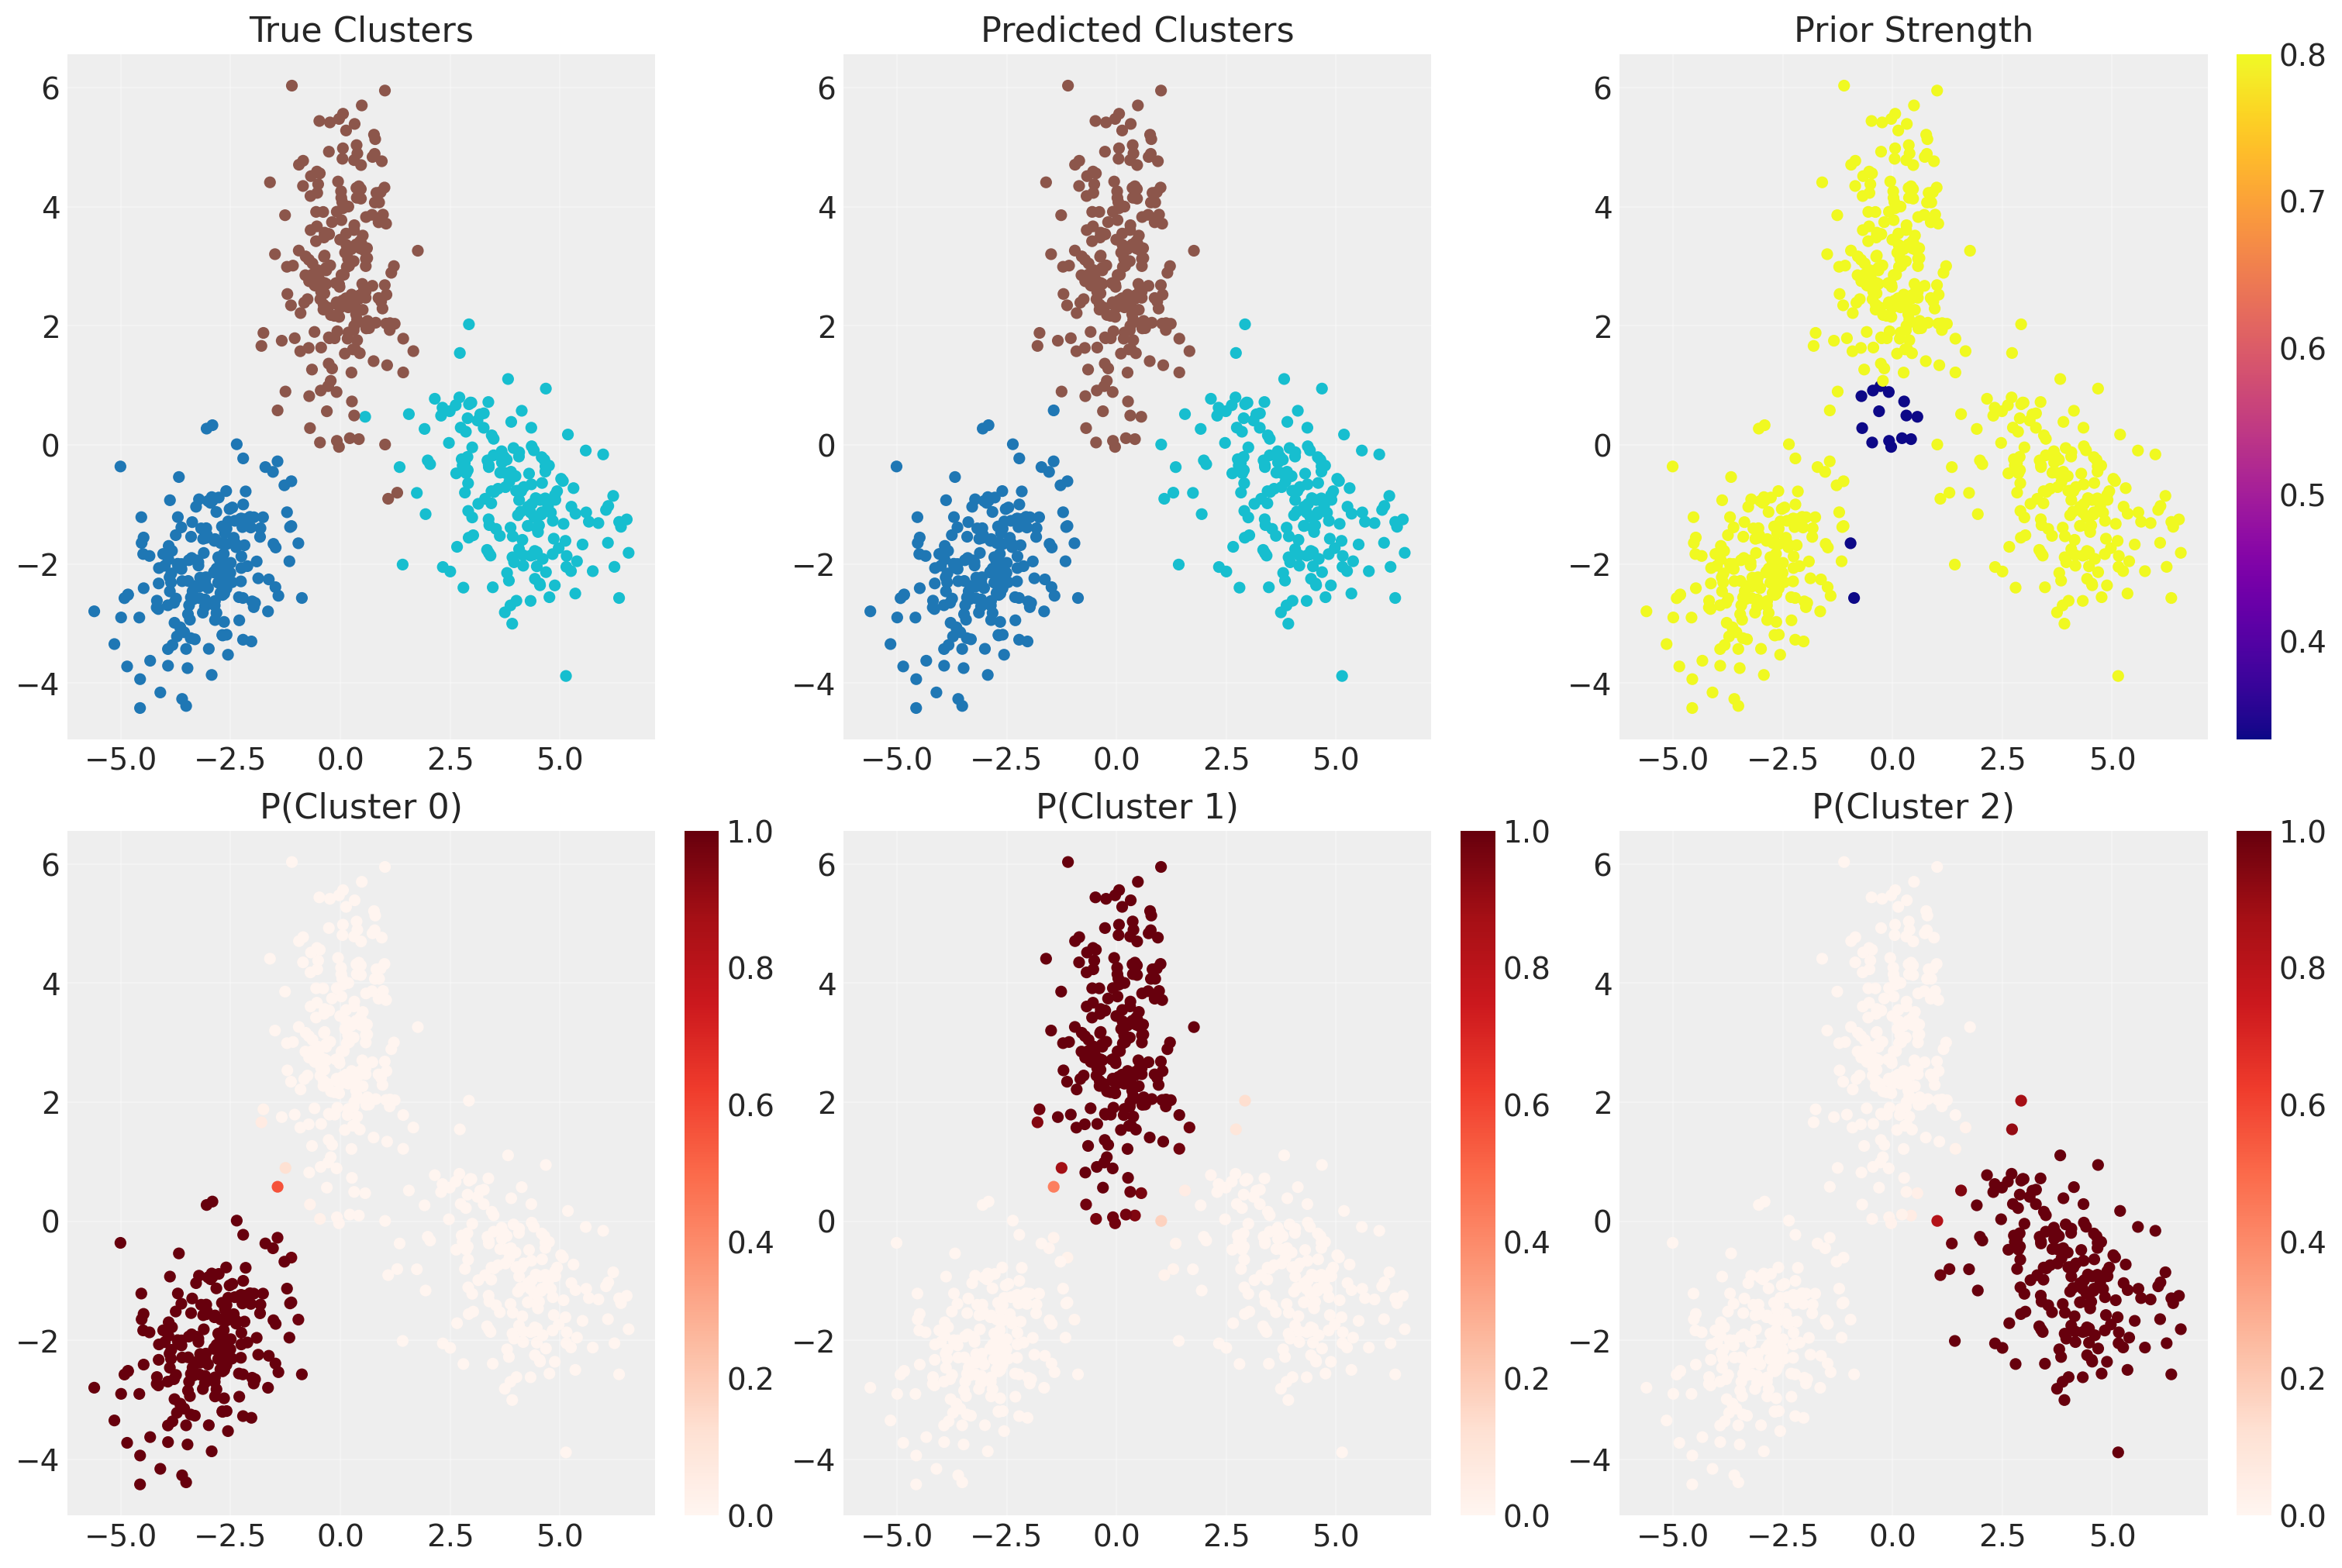

In [35]:
# Plot results
def plot_mixture_results(X, idata, prior_probs, true_labels):
    """Plot clustering results with uncertainty."""

    # Get posterior cluster assignments
    z_posterior = idata.posterior["z"]  # shape: (chain, draw, obs)

    # Most likely cluster for each point (compute mode manually)
    # Convert to numpy and find most frequent value along chain/draw dimensions
    z_samples = z_posterior.values  # shape: (chain, draw, obs)
    z_flat = z_samples.reshape(-1, z_samples.shape[-1])  # shape: (chain*draw, obs)

    cluster_pred = np.zeros(z_samples.shape[-1], dtype=int)
    for i in range(z_samples.shape[-1]):
        # Find mode (most frequent value) for each observation
        values, counts = np.unique(z_flat[:, i], return_counts=True)
        cluster_pred[i] = values[np.argmax(counts)]

    # Assignment probabilities
    z_probs = np.stack(
        [(z_posterior == k).mean(dim=["chain", "draw"]).values for k in range(3)],
        axis=1,
    )

    # Uncertainty (entropy)
    uncertainty = -np.sum(z_probs * np.log(z_probs + 1e-10), axis=1)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Row 1: True labels, Predicted labels, Prior influence
    scatter1 = axes[0, 0].scatter(X[:, 0], X[:, 1], c=true_labels, cmap="tab10", s=20)
    axes[0, 0].set_title("True Clusters")
    axes[0, 0].grid(True, alpha=0.3)

    scatter2 = axes[0, 1].scatter(X[:, 0], X[:, 1], c=cluster_pred, cmap="tab10", s=20)
    axes[0, 1].set_title("Predicted Clusters")
    axes[0, 1].grid(True, alpha=0.3)

    # Show which points were influenced by priors
    max_prior = np.max(prior_probs, axis=1)
    scatter3 = axes[0, 2].scatter(X[:, 0], X[:, 1], c=max_prior, cmap="plasma", s=20)
    axes[0, 2].set_title("Prior Strength")
    axes[0, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[0, 2])

    # Row 2: Assignment probabilities for each cluster
    for k in range(3):
        scatter = axes[1, k].scatter(
            X[:, 0], X[:, 1], c=z_probs[:, k], cmap="Reds", s=20, vmin=0, vmax=1
        )
        axes[1, k].set_title(f"P(Cluster {k})")
        axes[1, k].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1, k])

    return cluster_pred, z_probs, uncertainty


cluster_pred, z_probs, uncertainty = plot_mixture_results(
    X, idata, prior_probs, cluster_ids
)


In [42]:
# Compare with standard mixture (no priors)
with pm.Model(
    coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
) as model_no_prior:
    μ = pm.Normal("μ", mu=0, sigma=5, dims=("cluster", "feature"))
    σ = pm.HalfNormal("σ", sigma=3, dims=("cluster", "feature"))

    # Standard Dirichlet weights (uniform prior)
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")

    # Create component distributions manually for NormalMixture
    comp_dists = [
        pm.Normal.dist(mu=μ[i], sigma=σ[i], shape=(n_features,)) for i in range(k)
    ]

    # Use Mixture instead of NormalMixture for better control
    pm.Mixture(
        "x", w=weights, comp_dists=comp_dists, observed=X, dims=("obs", "feature")
    )

with model_no_prior:
    idata_no_prior = pm.sample(1000, tune=1000, target_accept=0.9)

# Compare accuracy
from sklearn.metrics import adjusted_rand_score

# Extract cluster assignments from no-prior model
# (This requires getting the most likely component assignment from NormalMixture)
# For simplicity, let's compute it approximately
posterior_means = idata_no_prior.posterior
μ_est = posterior_means["μ"].mean(dim=["chain", "draw"]).values
σ_est = posterior_means["σ"].mean(dim=["chain", "draw"]).values
w_est = posterior_means["w"].mean(dim=["chain", "draw"]).values

# Assign each point to most likely cluster (simplified)
from scipy.stats import multivariate_normal

log_probs = np.zeros((ndata, k))
for i in range(ndata):
    for j in range(k):
        log_probs[i, j] = np.log(w_est[j]) + multivariate_normal.logpdf(
            X[i], μ_est[j], np.diag(σ_est[j] ** 2)
        )

cluster_no_prior = np.argmax(log_probs, axis=1)

print("Clustering Accuracy (Adjusted Rand Index):")
print(f"With spatial priors: {adjusted_rand_score(cluster_ids, cluster_pred):.3f}")
print(f"Without priors: {adjusted_rand_score(cluster_ids, cluster_no_prior):.3f}")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, w]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Clustering Accuracy (Adjusted Rand Index):
With spatial priors: 0.975
Without priors: 0.896
